<b><font color="SteelBlue" size="+3">Implémentez un modèle de scoring</font></b>

# Introduction

Ce note book est la suite de l'EDA, il va permettre de présenter le prétraitement des données, le feature engineering et la modélisation.

In [1]:
# Chargement des librairies

# Built-in
import os
import re
import time
# Affichage
from IPython.display import Image

# Manipulation et analyse des données
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning - Suivi et Enregistrement
import mlflow
import mlflow.sklearn

# Machine Learning - Prétraitement
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.utils.class_weight import compute_class_weight

# Machine Learning - Algorithmes
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

# Machine Learning - Équilibrage des données
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning - Sélection de caractéristiques
from sklearn.feature_selection import RFECV

# Machine Learning - Évaluation des performances
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, make_scorer

# Transformateur
from sklearn.base import BaseEstimator, ClassifierMixin

# Data drift
from evidently.dashboard import Dashboard
from evidently.dashboard.tabs import DataDriftTab

# Custom Feature Engineering Pipeline
from feature_pipeline import FeatureEngineeringPipeline, remove_highly_correlated_features

In [2]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:5000")
mlflow.set_experiment("Credit_Scoring_Experiment")

<Experiment: artifact_location='mlflow-artifacts:/185199612184583695', creation_time=1715766694823, experiment_id='185199612184583695', last_update_time=1715766694823, lifecycle_stage='active', name='Credit_Scoring_Experiment', tags={}>

# Data préparation

## Chargement des données

In [3]:
os.listdir("data/sources/")

['application_test.csv',
 'application_train.csv',
 'bureau.csv',
 'bureau_balance.csv',
 'credit_card_balance.csv',
 'HomeCredit_columns_description.csv',
 'installments_payments.csv',
 'POS_CASH_balance.csv',
 'previous_application.csv',
 'Projet+Mise+en+prod+-+home-credit-default-risk.zip',
 'sample_submission.csv']

In [4]:
PATH = "./data/sources/"

In [5]:
application_train = pd.read_csv(PATH+"/application_train.csv")
application_test = pd.read_csv(PATH+"/application_test.csv")
bureau = pd.read_csv(PATH+"/bureau.csv")
bureau_balance = pd.read_csv(PATH+"/bureau_balance.csv")
credit_card_balance = pd.read_csv(PATH+"/credit_card_balance.csv")
installments_payments = pd.read_csv(PATH+"/installments_payments.csv")
previous_application = pd.read_csv(PATH+"/previous_application.csv")
POS_CASH_balance = pd.read_csv(PATH+"/POS_CASH_balance.csv")

## Split du jeu de données

In [6]:
# Division des données en ensembles d'entraînement et de test
train, test = train_test_split(application_train, test_size=0.2, random_state=42, stratify=application_train['TARGET'])

In [7]:
train.shape

(246008, 122)

## Gestion des valeurs manquantes et infinies

In [8]:
# Supprimer les lignes où TARGET est manquant dans application_train
train.dropna(subset=['TARGET'], inplace=True)
test.dropna(subset=['TARGET'], inplace=True)

In [9]:
# Suppression des lignes où les clés sont absentes
def drop_missing_keys(df, key, reference_df, reference_key):
    valid_keys = reference_df[reference_key].unique()
    return df[df[key].isin(valid_keys)]

# Supprimer les lignes où les clés sont absentes
bureau = drop_missing_keys(bureau, 'SK_ID_CURR', application_train, 'SK_ID_CURR')
bureau_balance = drop_missing_keys(bureau_balance, 'SK_ID_BUREAU', bureau, 'SK_ID_BUREAU')
previous_application = drop_missing_keys(previous_application, 'SK_ID_CURR', application_train, 'SK_ID_CURR')
POS_CASH_balance = drop_missing_keys(POS_CASH_balance, 'SK_ID_PREV', previous_application, 'SK_ID_PREV')
installments_payments = drop_missing_keys(installments_payments, 'SK_ID_PREV', previous_application, 'SK_ID_PREV')
credit_card_balance = drop_missing_keys(credit_card_balance, 'SK_ID_PREV', previous_application, 'SK_ID_PREV')

In [10]:
# Remplacement des valeurs infinie par nan
def replace_infinite_values(df):
    return df.replace([np.inf, -np.inf], np.nan)

In [11]:
# Appliquer le filtre des colonnes manquantes et la gestion des valeurs infinies à chaque DataFrame
dfs = {
    "Train": train,
    "Test": test,
    "Application Test": application_test,
    "Bureau": bureau,
    "Bureau Balance": bureau_balance,
    "Credit Card Balance": credit_card_balance,
    "Installments Payments": installments_payments,
    "Previous Application": previous_application,
    "POS CASH Balance": POS_CASH_balance
}

In [12]:
for name, df in dfs.items():
    df = replace_infinite_values(df)
    dfs[name] = df

In [13]:
dfs['Train'].shape

(246008, 122)

## Imputation

In [14]:
dfs_imputed = dfs

In [15]:
# Fonction pour imputer les valeurs manquantes
def impute_missing_values(df):
    # Imputation pour les colonnes numériques
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # Imputation pour les colonnes catégorielles
    categorical_cols = df.select_dtypes(include=[object]).columns
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)
    
    return df

In [16]:
for name, df in dfs_imputed.items():
    df = impute_missing_values(df)
    dfs_imputed[name] = df

In [17]:
# Fonction pour vérifier les valeurs manquantes dans un DataFrame
def check_missing_values(df):
    missing_values = df.isnull().sum()
    missing_values = missing_values[missing_values > 0]
    if not missing_values.empty:
        print("Colonnes avec des valeurs manquantes :")
        print(missing_values)
    else:
        print("Aucune valeur manquante détectée.")


In [18]:
# Vérification des valeurs manquantes dans chaque DataFrame
for name, df in dfs_imputed.items():
    print(f"\n{name}:")
    check_missing_values(df)


Train:
Aucune valeur manquante détectée.

Test:
Aucune valeur manquante détectée.

Application Test:
Aucune valeur manquante détectée.

Bureau:
Aucune valeur manquante détectée.

Bureau Balance:
Aucune valeur manquante détectée.

Credit Card Balance:
Aucune valeur manquante détectée.

Installments Payments:
Aucune valeur manquante détectée.

Previous Application:
Aucune valeur manquante détectée.

POS CASH Balance:
Aucune valeur manquante détectée.


In [19]:
dfs_imputed['Train'].shape

(246008, 122)

## Sauvegarde des données nettoyées

In [19]:
# Fonction pour sauvegarder un DataFrame
def save_dataframe(df, filename, output_dir):
    output_path = os.path.join(output_dir, filename)
    df.to_csv(output_path, index=False)
    print(f"DataFrame sauvegardé sous : {output_path}")

In [21]:
# Dictionnaire contenant les noms des fichiers
original_names = {
    "Train": "train.csv",
    "Test": "test.csv",
    "Application Test": "application_test.csv",
    "Bureau": "bureau.csv",
    "Bureau Balance": "bureau_balance.csv",
    "Credit Card Balance": "credit_card_balance.csv",
    "Installments Payments": "installments_payments.csv",
    "Previous Application": "previous_application.csv",
    "POS CASH Balance": "POS_CASH_balance.csv"
}

### Sans l'imputation

In [22]:
# Chemin du dossier où sauvegarder les DataFrames nettoyés
output_dir = "data/Cleaned"

In [23]:
# Sauvegarder chaque DataFrame dans le dossier output_dir avec le nom d'origine
for name, df in dfs.items():
    save_dataframe(df, original_names[name], output_dir)

DataFrame sauvegardé sous : data/Cleaned\train.csv
DataFrame sauvegardé sous : data/Cleaned\test.csv
DataFrame sauvegardé sous : data/Cleaned\application_test.csv
DataFrame sauvegardé sous : data/Cleaned\bureau.csv
DataFrame sauvegardé sous : data/Cleaned\bureau_balance.csv
DataFrame sauvegardé sous : data/Cleaned\credit_card_balance.csv
DataFrame sauvegardé sous : data/Cleaned\installments_payments.csv
DataFrame sauvegardé sous : data/Cleaned\previous_application.csv
DataFrame sauvegardé sous : data/Cleaned\POS_CASH_balance.csv


### Avec l'imputation

In [24]:
# Chemin du dossier où sauvegarder les DataFrames nettoyés
output_dir_imputed = "data/Cleaned/Imputed"

In [25]:
# Sauvegarder chaque DataFrame dans le dossier output_dir avec le nom d'origine
for name, df in dfs_imputed.items():
    save_dataframe(df, original_names[name], output_dir_imputed)

DataFrame sauvegardé sous : data/Cleaned/Imputed\train.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\test.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\application_test.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\bureau.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\bureau_balance.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\credit_card_balance.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\installments_payments.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\previous_application.csv
DataFrame sauvegardé sous : data/Cleaned/Imputed\POS_CASH_balance.csv


# Feature engineering

## Sur jeu non imputé

### Sur le df train

In [26]:
# Initialiser le pipeline
pipeline = FeatureEngineeringPipeline(data_directory=output_dir + '/')

In [27]:
# Entraîner le pipeline
train_transformed = pipeline.fit(dfs['Train'])

feature_engineering - done
Bureau and bureau_balance data - done in 36s
previous_application - done in 40s
previous applications balances - done in 494s
Gestion des valeurs infinies
Colonnes supprimées: 190, Colonnes restantes: 543
Colonnes supprimées (constantes): 0, Colonnes restantes: 543
Initial df memory usage is 1025.94 MB for 661 columns
Final memory usage is: 373.49 MB - decreased by 63.6%


In [28]:
# Sauvegarder les paramètres de transformation
pipeline.save(os.path.join(output_dir, "param"))

In [29]:
train_transformed.shape

(246003, 661)

In [30]:
train_transformed.head(5)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
183096,1,0,0,0,1,0,135000.0,161730.0,8464.5,135000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
433941,0,0,0,1,0,0,225000.0,729792.0,22126.5,630000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
378379,0,0,1,0,1,0,121500.0,911263.5,36270.0,814500.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
301108,0,0,0,0,1,0,180000.0,808650.0,23773.5,675000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
194730,0,0,1,1,1,0,180000.0,355536.0,15192.0,270000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [31]:
check_missing_values(train_transformed)

Colonnes avec des valeurs manquantes :
DAYS_EMPLOYED                       44589
DAYS_LAST_PHONE_CHANGE              30094
INCOME_TO_EMPLOYED_RATIO            44591
EMPLOYED_TO_BIRTH_RATIO             44589
CAR_TO_EMPLOYED_RATIO               44591
                                    ...  
CTA_CREDIT_TO_ANNUITY_MEAN_RATIO    13990
DAYS_DECISION_MEAN_TO_BIRTH         13977
DAYS_CREDIT_MEAN_TO_BIRTH           35323
DAYS_DECISION_MEAN_TO_EMPLOYED      56182
DAYS_CREDIT_MEAN_TO_EMPLOYED        73145
Length: 397, dtype: int64


### Sur le df test

In [33]:
# Charger les paramètres de transformation
pipeline.load(os.path.join(output_dir, "param"))

# Transformer les données de test
test_transformed = pipeline.transform(dfs['Test'])

Bureau and bureau_balance data - done in 36s
previous_application - done in 38s
Gestion des valeurs infinies
Colonnes supprimées: 190, Colonnes restantes: 543
Initial df memory usage is 309.46 MB for 661 columns
Final memory usage is: 85.69 MB - decreased by 72.3%
previous applications balances - done in 497s


In [34]:
test_transformed.shape

(61503, 661)

## Sur jeu imputé

### Sur le df train

In [35]:
# Initialiser le pipeline
pipeline_imp = FeatureEngineeringPipeline(data_directory=output_dir_imputed + '/')

In [36]:
# Entraîner le pipeline
train_imputed_transformed = pipeline_imp.fit(dfs_imputed['Train'])

feature_engineering - done
Bureau and bureau_balance data - done in 35s
previous_application - done in 38s
previous applications balances - done in 494s
Gestion des valeurs infinies
Colonnes supprimées: 190, Colonnes restantes: 543
Gestion des valeurs manquantes - done
Colonnes supprimées (constantes): 0, Colonnes restantes: 543
Initial df memory usage is 1025.94 MB for 661 columns
Final memory usage is: 373.49 MB - decreased by 63.6%


In [37]:
# Sauvegarder les paramètres de transformation
pipeline_imp.save(os.path.join(output_dir_imputed, "param"))

In [38]:
train_imputed_transformed.shape

(246003, 661)

In [39]:
train_imputed_transformed.head(5)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
183096,1,0,0,0,1,0,135000.0,161730.0,8464.5,135000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
433941,0,0,0,1,0,0,225000.0,729792.0,22126.5,630000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
378379,0,0,1,0,1,0,121500.0,911263.5,36270.0,814500.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
301108,0,0,0,0,1,0,180000.0,808650.0,23773.5,675000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
194730,0,0,1,1,1,0,180000.0,355536.0,15192.0,270000.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [40]:
check_missing_values(train_imputed_transformed)

Aucune valeur manquante détectée.


### Sur le df test

In [42]:
# Charger les paramètres de transformation
pipeline_imp.load(os.path.join(output_dir_imputed, "param"))

# Transformer les données de test
test_imputed_transformed = pipeline_imp.transform(dfs_imputed['Test'])

Bureau and bureau_balance data - done in 36s
previous_application - done in 38s
Gestion des valeurs infinies
Colonnes supprimées: 190, Colonnes restantes: 543
Gestion des valeurs manquantes - done
Initial df memory usage is 309.46 MB for 661 columns
Final memory usage is: 85.69 MB - decreased by 72.3%
previous applications balances - done in 496s


In [44]:
test_imputed_transformed.shape

(61503, 661)

In [45]:
# Vérification des colonnes avec des valeurs manquantes
missing_values = test_imputed_transformed.isnull().sum()
missing_columns = missing_values[missing_values > 0].index.tolist()
print(f"Colonnes avec des valeurs manquantes : {missing_columns}")

Colonnes avec des valeurs manquantes : []


## Sauvegarde / Chargement des données

In [46]:
output_feat_dir = "data/Featured"

# Enregistrer les DataFrames dans des fichiers CSV
train_transformed.to_csv(os.path.join(output_feat_dir, "train_transformed.csv"), index=False)
test_transformed.to_csv(os.path.join(output_feat_dir, "test_transformed.csv"), index=False)
train_imputed_transformed.to_csv(os.path.join(output_feat_dir, "train_imputed_transformed.csv"), index=False)
test_imputed_transformed.to_csv(os.path.join(output_feat_dir, "test_imputed_transformed.csv"), index=False)

print("DataFrames enregistrés avec succès.")

DataFrames enregistrés avec succès.


In [3]:
# Vérification de l'existence de la variable output_feat_dir
try:
    output_feat_dir
except NameError:
    output_feat_dir = None

if output_feat_dir is None:
    output_feat_dir = "data/Featured"

    # Charger les DataFrames à partir des fichiers CSV
    train_transformed = pd.read_csv(os.path.join(output_feat_dir, "train_transformed.csv"))
    test_transformed = pd.read_csv(os.path.join(output_feat_dir, "test_transformed.csv"))
    train_imputed_transformed = pd.read_csv(os.path.join(output_feat_dir, "train_imputed_transformed.csv"))
    test_imputed_transformed = pd.read_csv(os.path.join(output_feat_dir, "test_imputed_transformed.csv"))

    print("DataFrames chargés avec succès.")

DataFrames chargés avec succès.


In [4]:
print(f"train_transformed : {train_transformed.shape},\n"
      f"test_transformed : {test_transformed.shape},\n"
      f"train_imputed_transformed : {train_imputed_transformed.shape},\n"
      f"test_imputed_transformed : {test_imputed_transformed.shape}")

train_transformed : (246003, 661),
test_transformed : (61503, 661),
train_imputed_transformed : (246003, 661),
test_imputed_transformed : (61503, 661)


In [5]:
# nettoyage des noms de colonnes
def clean_column_names(df):
    df.columns = [re.sub(r'[^A-Za-z0-9_]+', '', col) for col in df.columns]
    return df

train_transformed = clean_column_names(train_transformed)
test_transformed = clean_column_names(test_transformed)
train_imputed_transformed = clean_column_names(train_imputed_transformed)
test_imputed_transformed = clean_column_names(test_imputed_transformed)

# Définition du Score Métier

In [6]:
def normalized_cost_function(y_true, y_pred):
    fp_cost = 1
    fn_cost = 10
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fn = np.sum((y_true == 1) & (y_pred == 0))
    cost = (fp_cost * fp + fn_cost * fn) / len(y_true)
    return cost

In [7]:
# Création du custom score avec la fonction cost
custom_scorer = make_scorer(normalized_cost_function, greater_is_better=False)

# Modèles de machine learning

## Préparation

In [8]:
# Séparer les features et la cible sur le jeu sans imputation
X_train = train_transformed.drop(columns=['TARGET'])
y_train = train_transformed['TARGET']
X_test = test_transformed.drop(columns=['TARGET'])
y_test = test_transformed['TARGET']

In [9]:
# Séparer les features et la cible sur le jeu imputé
X_train_imputed = train_imputed_transformed.drop(columns=['TARGET'])
y_train_imputed = train_imputed_transformed['TARGET']
X_test_imputed = test_imputed_transformed.drop(columns=['TARGET'])
y_test_imputed = test_imputed_transformed['TARGET']

### Séléction des variables

#### Suppression des variables hautement corrélées

In [10]:
train_cleaned, high_corr_features = remove_highly_correlated_features(train_transformed, threshold=0.9)
print(f"Variables très corrélées supprimées: {len(high_corr_features)}")

Variables très corrélées supprimées: 151


In [11]:
train_cleaned.shape

(246003, 510)

In [12]:
# Aligner les colones du jeu de test

train_cleaned_columns = list(train_cleaned.columns)
test_cleaned = test_transformed.copy()

# Supprimer les colonnes en trop
extra_cols = set(test_cleaned.columns) - set(train_cleaned_columns)
if extra_cols:
    test_cleaned.drop(columns=list(extra_cols), inplace=True)

# Réordonner les colonnes pour correspondre à celles du train
test_cleaned = test_cleaned[train_cleaned_columns]

test_cleaned.shape

(61503, 510)

In [13]:
# Séparer les features et la cible
X_train = train_cleaned.drop(columns=['TARGET'])
y_train = train_cleaned['TARGET']
X_test = test_cleaned.drop(columns=['TARGET'])
y_test = test_cleaned['TARGET']

#### Recherche de la feature importance (CatBoost + RFECV)

In [14]:
# Modèle CatBoost
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_catboost = class_weights.tolist()
catboost_model = CatBoostClassifier(verbose=0, class_weights=class_weights_catboost, thread_count=-1, task_type="GPU", random_seed=42)

In [197]:
# Entrainer le modèle
catboost_model.fit(X_train, y_train)

# Obtenir l'importance des caractéristiques
feature_importances = catboost_model.get_feature_importance()
sorted_idx = np.argsort(feature_importances)[::-1]

# Fonction pour évaluer le modèle avec un sous-ensemble de caractéristiques
def evaluate_model_with_features(n_features, X_train, y_train, X_test, y_test):
    selected_features = sorted_idx[:n_features]
    X_train_selected = X_train.iloc[:, selected_features]
    X_test_selected = X_test.iloc[:, selected_features]
    
    catboost_model.fit(X_train_selected, y_train)
    y_pred_proba = catboost_model.predict_proba(X_test_selected)[:, 1]
    score = roc_auc_score(y_test, y_pred_proba)
    return score

In [200]:
# Liste pour stocker les scores
mean_scores = []
n_features_list = range(40, 400, 10)

# Boucle pour évaluer le modèle avec différents nombres de caractéristiques
for n_features in n_features_list:
    score = evaluate_model_with_features(n_features, X_train, y_train, X_test, y_test)
    mean_scores.append(score)

# Trouver le nombre optimal de caractéristiques
optimal_n_features = n_features_list[np.argmax(mean_scores)]
print("Nombre optimal de caractéristiques:", optimal_n_features)

Nombre optimal de caractéristiques: 190


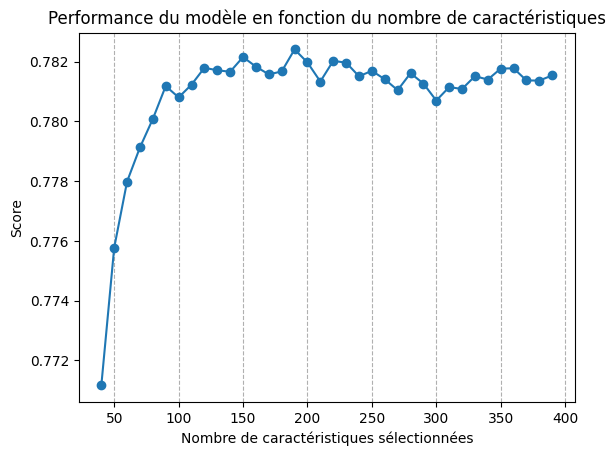

In [201]:
# Tracer les scores
plt.plot(n_features_list, mean_scores, marker='o')
plt.xlabel('Nombre de caractéristiques sélectionnées')
plt.ylabel('Score')
plt.title('Performance du modèle en fonction du nombre de caractéristiques')
plt.grid(axis='x', linestyle='--')
plt.show()

In [ ]:
# Créer une instance de RFECV avec CatBoostClassifier
rfecv = RFECV(
    estimator=catboost_model,
    step=1, 
    cv=StratifiedKFold(5), 
    scoring=make_scorer(roc_auc_score),
    verbose=0,
    n_jobs=-1 
)

In [16]:
# Entraîner le RFECV sur les données d'entraînement
rfecv.fit(X_train, y_train)

Fitting estimator with 509 features.
Fitting estimator with 508 features.
Fitting estimator with 507 features.
Fitting estimator with 506 features.
Fitting estimator with 505 features.
Fitting estimator with 504 features.
Fitting estimator with 503 features.
Fitting estimator with 502 features.
Fitting estimator with 501 features.
Fitting estimator with 500 features.
Fitting estimator with 499 features.
Fitting estimator with 498 features.
Fitting estimator with 497 features.
Fitting estimator with 496 features.
Fitting estimator with 495 features.
Fitting estimator with 494 features.
Fitting estimator with 493 features.
Fitting estimator with 492 features.
Fitting estimator with 491 features.
Fitting estimator with 490 features.
Fitting estimator with 489 features.
Fitting estimator with 488 features.
Fitting estimator with 487 features.
Fitting estimator with 486 features.
Fitting estimator with 485 features.
Fitting estimator with 484 features.
Fitting estimator with 483 features.
F

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=<catboost.core.CatBoostClassifier object at 0x000001CC56E8E240>,
      scoring=make_scorer(roc_auc_score, response_method='predict'), verbose=1)

In [21]:
# Obtenir le nombre optimal de caractéristiques
optimal_n_features = rfecv.n_features_
print(f"Nombre optimal de caractéristiques: {optimal_n_features}")

Nombre optimal de caractéristiques: 322


In [22]:
# Obtenir la liste des caractéristiques sélectionnées
selected_features_mask = rfecv.support_
selected_features_list = X_train.columns[selected_features_mask].tolist()

# Créer un DataFrame avec les caractéristiques sélectionnées
selected_features = pd.DataFrame(selected_features_list, columns=["Selected Features"])

In [23]:
selected_features.shape

(322, 1)

#### Sauvegarde / Chargement des features

In [24]:
# Sauvegarde des features selectionnées
save_dataframe(selected_features, "features.csv", output_feat_dir)

DataFrame sauvegardé sous : data/Featured\features.csv


In [25]:
# Charger la liste des features selectionnées
# Vérification de l'existence de la variable selected_features
try:
    selected_features
except NameError:
    selected_features = None

if selected_features is None:
    # Définir la variable selected_features ici
    selected_features = pd.read_csv(os.path.join(output_feat_dir, "features.csv"))
    print("Features chargés avec succès.")

    # Séparer les features et la cible sur le jeu imputé
    X_train_imputed = train_imputed_transformed.drop(columns=['TARGET'])
    y_train_imputed = train_imputed_transformed['TARGET']
    X_test_imputed = test_imputed_transformed.drop(columns=['TARGET'])
    y_test_imputed = test_imputed_transformed['TARGET']

    selected_features_list = selected_features.iloc[:, 0].tolist()

In [26]:
X_train.shape

(246003, 509)

In [27]:
# Filtrer les jeux de données pour ne garder que les features sélectionnées
X_train_imp_selected = train_imputed_transformed[selected_features_list]
X_test_imp_selected = test_imputed_transformed[selected_features_list]

# idem sur jeu non imputé
X_train_selected = X_train[selected_features_list]
X_test_selected = X_test[selected_features_list]

In [28]:
X_train_imp_selected.shape

(246003, 322)

In [29]:
X_test_imp_selected.shape

(61503, 322)

In [30]:
X_train_selected.shape

(246003, 322)

In [100]:
type(y_test_imputed)

pandas.core.series.Series

### Standardisation

In [164]:
# Normaliser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp_selected)
X_test_scaled = scaler.transform(X_test_imp_selected)

In [165]:
X_train_scaled.shape

(246003, 322)

### Ensemble de validation

In [34]:
# Division des données d'entraînement en sous-ensembles d'entraînement et de validation sur jeu non imputé
X_train_part, X_val_part, y_train_part, y_val_part = train_test_split(X_train_selected, y_train,
                                                                      test_size=0.2, random_state=42,
                                                                      stratify=y_train)

In [35]:
# Division des données d'entraînement en sous-ensembles d'entraînement et de validation sur jeu imputé
X_train_imp_part, X_val_imp_part, y_train_imp_part, y_val_imp_part = train_test_split(X_train_imp_selected, y_train_imputed,
                                                                                      test_size=0.2, random_state=42,
                                                                                      stratify=y_train_imputed)

## Tests de différents modèles

In [36]:
# Liste des modèles à tester
dummy_model = DummyClassifier(strategy='most_frequent')
logistic_model = LogisticRegression(random_state=42, max_iter=2000, n_jobs=-1)

# Calcul de scale_pos_weight pour XGBoost
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
xgb_model_weight = XGBClassifier(scale_pos_weight=scale_pos_weight, n_jobs=-1, use_label_encoder=False,
                                 eval_metric='logloss', random_state=42)
xgb_model = XGBClassifier(n_jobs=-1, use_label_encoder=False, eval_metric='logloss', random_state=42)

lgbm_model_ub = LGBMClassifier(verbose=0, n_jobs=-1, is_unbalance=True, verbosity=-1, random_state=42)
lgbm_model = LGBMClassifier(verbose=0, n_jobs=-1, is_unbalance=False, random_state=42)

# Calcul des poids de classe pour catboost
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_catboost = class_weights.tolist()
catboost_model_weight = CatBoostClassifier(verbose=0, class_weights=class_weights_catboost, thread_count=-1, task_type="GPU", random_seed=42)

catboost_model = CatBoostClassifier(verbose=0, thread_count=-1, task_type="GPU", random_seed=42)

In [177]:
# Fonction pour préparer les données avec différentes techniques de rééquilibrage
def prepare_data(need_imputation, need_scaling, need_validation, technique=None):

    if need_imputation:
        if need_validation:
            #print("Avec imputation, sans scaling, avec validation")
            X_train_loc, y_train_loc = X_train_imp_part, y_train_imp_part
            X_val, y_val = X_val_imp_part, y_val_imp_part
            X_test_loc, y_test_loc = X_test_imp_selected, y_test_imputed
        else:
            if need_scaling:
                #print("Avec Imputation, avec scaling, sans validation")
                X_train_loc, y_train_loc = X_train_scaled, y_train_imputed
                X_test_loc, y_test_loc = X_test_scaled, y_test_imputed
            else:
                #print("Avec Imputation, sans scaling, sans validation")
                X_train_loc, y_train_loc = X_train_imp_selected, y_train_imputed
                X_test_loc, y_test_loc = X_test_imp_selected, y_test_imputed
            X_val, y_val = None, None
    else:
        if need_validation:
            #print("Sans imputation, sans scaling, avec validation")
            X_train_loc, y_train_loc = X_train_part, y_train_part
            X_val, y_val = X_val_part, y_val_part
        else:
            #print("Sans imputation, sans scaling, sans validation")
            X_train_loc, y_train_loc = X_train_selected, y_train
            X_val, y_val = None, None
        X_test_loc, y_test_loc = X_test_selected, y_test
        
    
    if technique == "SMOTE":
        smote = SMOTE(random_state=42)
        X_res, y_res = smote.fit_resample(X_train_loc, y_train_loc)
    elif technique == "Undersampling":
        undersample = RandomUnderSampler(random_state=42)
        X_res, y_res = undersample.fit_resample(X_train_loc, y_train_loc)
    else:
        X_res, y_res = X_train_loc, y_train_loc
    #print(f"X_res :{X_res.shape}")
    return X_res, y_res, X_val, y_val, X_test_loc, y_test_loc

### Ensemble de validation fixe

In [38]:
# Fonction pour calculer le taux de FN et FP
def calculate_fn_fp_rates(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    fn_rate = fn / (fn + tp) if (fn + tp) > 0 else 0
    fp_rate = fp / (fp + tn) if (fp + tn) > 0 else 0
    return fn_rate, fp_rate

In [39]:
results=[]

# Fonction pour entraîner et enregistrer les modèles avec MLFlow
def train_and_log_model(model, model_name, need_imputation=True, need_scaling=False, need_validation=False, technique=None, best_params=None):
    with mlflow.start_run(run_name=f"{model_name}"):
        # lancement du timer
        start_time = time.time()
    
        # préparation des données
        X_train_loc, y_train_loc, X_val, y_val, X_test_loc, y_test_loc = prepare_data(need_imputation, need_scaling,
                                                                                      need_validation, technique)

        # Appliquer les meilleurs hyperparamètres
        if best_params:
            model.set_params(**best_params)
    
        # entrainement du modèle
        if "LightGBM" in model_name:
            model.fit(X_train_loc, y_train_loc, eval_set=[(X_val, y_val)], callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
        elif "CatBoost" in model_name:
            eval_dataset = Pool(X_val, y_val)
            model.fit(X_train_loc, y_train_loc, eval_set=eval_dataset, early_stopping_rounds=50, verbose=False)
        else:
            # Entraînement des modèles qui n'utilisent pas d'ensemble de validation
            model.fit(X_train_loc, y_train_loc)

        # timer d'entrainement
        training_time = time.time() - start_time

        # lancement du timer
        start_time = time.time()
        
        y_pred_proba = model.predict_proba(X_test_loc)[:, 1]
        y_pred = (y_pred_proba >= 0.5).astype(int)

        # timer de prediction
        prediction_time = time.time() - start_time
        
        auc_score = roc_auc_score(y_test_loc, y_pred_proba)       
        accuracy = accuracy_score(y_test_loc, y_pred)
        custom_score = -normalized_cost_function(y_test_loc, y_pred)

        # Calculer les taux de FN et FP
        fn_rate, fp_rate = calculate_fn_fp_rates(y_test, y_pred)
        
        mlflow.log_param("model", model_name)
        mlflow.log_param("balancing_technique", technique)
        mlflow.log_metric("ROC AUC", auc_score)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Custom Score", custom_score)
        mlflow.log_metric("FN Rate", fn_rate)
        mlflow.log_metric("FP Rate", fp_rate)
        mlflow.log_metric("Training Time", training_time)
        mlflow.log_metric("Prediction Time", prediction_time)
        
        mlflow.sklearn.log_model(model, f"{model_name}")

        print(f"{model_name} - ROC AUC: {auc_score}, Accuracy: {accuracy}, Custom Score: {custom_score}")

            # Ajouter les résultats au DataFrame
    results.append({
        "Model": model_name,
        "ROC AUC": auc_score,
        "Accuracy": accuracy,
        "Custom Score": custom_score,
        "FN Rate": fn_rate,
        "FP Rate": fp_rate,
        "Training Time": training_time,
        "Prediction Time": prediction_time
    })

In [40]:
# Liste des modèles à tester
model_datasets = {
    "Dummy Classifier": (dummy_model, True, False, False, None, None),
    "Logistic Regression": (logistic_model, True, True, False, None, None),
    "Logistic Regression SMOTE": (logistic_model, True, True, False, "SMOTE", None),
    "Logistic Regression Undersampling": (logistic_model, True, True, False, "Undersampling", None),
    "XGBoost": (xgb_model, True, False, False, None, None),
    "XGBoost with weight": (xgb_model_weight, True, False, False, None, None),
    "LightGBM": (lgbm_model, False, False, True, None, None),
    "LightGBM with unbalanced": (lgbm_model_ub, False, False, True, None, None),
    "CatBoost": (catboost_model, False, False, True, None, None),
    "CatBoost with weight": (catboost_model_weight, False, False, True, None, None),
}

In [41]:
# Entraîner et évaluer chaque modèle
for model_name, dfs in model_datasets.items():
    print(f"Evaluating {model_name}")
    train_and_log_model(dfs[0], model_name, dfs[1], dfs[2], dfs[3], dfs[4], dfs[5])

# Afficher les résultats
results_df = pd.DataFrame(results)
results_df.sort_values(by="ROC AUC", ascending=False)

Evaluating Dummy Classifier
Dummy Classifier - ROC AUC: 0.5, Accuracy: 0.9192722306228964, Custom Score: -0.8072776937710355
Evaluating Logistic Regression
Logistic Regression - ROC AUC: 0.7717462294072587, Accuracy: 0.9193697868396663, Custom Score: -0.7883030096092873
Evaluating Logistic Regression SMOTE
Logistic Regression SMOTE - ROC AUC: 0.7596765778860884, Accuracy: 0.7335577126319042, Custom Score: -0.5276490577695397
Evaluating Logistic Regression Undersampling
Logistic Regression Undersampling - ROC AUC: 0.7701584657283143, Accuracy: 0.7027624668715348, Custom Score: -0.5114709851551957
Evaluating XGBoost
XGBoost - ROC AUC: 0.7617625137610305, Accuracy: 0.9191258962977416, Custom Score: -0.7686454319301498
Evaluating XGBoost with weight
XGBoost with weight - ROC AUC: 0.7587257375614943, Accuracy: 0.7793440970359169, Custom Score: -0.5297139976911696
Evaluating LightGBM
LightGBM - ROC AUC: 0.7739329966812507, Accuracy: 0.9197274929678227, Custom Score: -0.7899939840332992
Evalu

,Model,ROC AUC,Accuracy,Custom Score,FN Rate,FP Rate,Training Time,Prediction Time
8,CatBoost,0.780738,0.920053,-0.781035,0.964955,0.002229,11.504220,0.062519
9,CatBoost with weight,0.779953,0.745037,-0.501683,0.339577,0.247533,9.672038,0.053015
6,LightGBM,0.773933,0.919727,-0.789994,0.976838,0.001539,7.441675,0.159539
1,Logistic Regression,0.771746,0.919370,-0.788303,0.974018,0.002176,7.773101,0.024508
3,Logistic Regression Undersampling,0.770158,0.702762,-0.511471,0.294864,0.297446,2.276067,0.023630
4,XGBoost,0.761763,0.919126,-0.768645,0.946626,0.004846,24.764781,0.290058
2,Logistic Regression SMOTE,0.759677,0.733558,-0.527649,0.359517,0.258269,55.985479,0.025007
5,XGBoost with weight,0.758726,0.779344,-0.529714,0.425378,0.202678,24.854205,0.287973
7,LightGBM with unbalanced,0.723538,0.919272,-0.807278,1.000000,0.000000,5.105591,0.127531
0,Dummy Classifier,0.500000,0.919272,-0.807278,1.000000,0.000000,0.006002,0.000000


### Validation croisée

In [178]:
# selection des modèles prometteurs
model_datasets_cv = {
    "Logistic Regression": (logistic_model, True, True, False, None),
    "Logistic Regression SMOTE": (logistic_model, True, True, False, "SMOTE"),
    "Logistic Regression Undersampling": (logistic_model, True, True, False, "Undersampling"),
    "XGBoost": (xgb_model, True, False, False, None),
    "XGBoost with weight": (xgb_model_weight, True, False, False, None),
    "LightGBM": (lgbm_model, False, False, False, None),
    "LightGBM with unbalanced": (lgbm_model_ub, False, False, False, None),
    "CatBoost": (catboost_model, False, False, False, None),
    "CatBoost with weight": (catboost_model_weight, False, False, False, None),
}

In [184]:
# Fonction pour effectuer une validation croisée et évaluer les modèles
def cross_validate_model(model, X, y, scoring=custom_scorer):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(roc_auc_score))
    accuracy_scores = cross_val_score(model, X, y, cv=skf, scoring=make_scorer(accuracy_score))
    scores = cross_val_score(model, X, y, cv=skf, scoring=scoring)
    return np.mean(auc_scores), np.mean(accuracy_scores), np.mean(scores)

In [ ]:
# Liste pour stocker les résultats
results = []

# Entraîner et évaluer chaque modèle
for model_name, dfs in model_datasets_cv.items():
    print(f"Evaluating {model_name}")
    # préparation des données
    X_train_loc, y_train_loc, X_val_loc, y_val_loc, X_test_loc, y_test_loc = prepare_data(dfs[1], dfs[2], dfs[3], dfs[4])

    # CV
    auc, accuracy, custom_score = cross_validate_model(dfs[0], X_train_loc, y_train_loc, custom_scorer)
    
    # Enregistrer les résultats dans MLflow
    with mlflow.start_run(run_name=f"{model_name}_CV"):
        mlflow.log_param("model", model_name)
        mlflow.log_metric("ROC AUC", auc)
        mlflow.log_metric("Accuracy", accuracy)
        mlflow.log_metric("Custom Score", custom_score)
        mlflow.sklearn.log_model(dfs[0], f"{model_name}")

    print(f"{model_name} - ROC AUC: {auc}, Accuracy: {accuracy}, Custom Score: {custom_score}")

    # Ajouter les résultats au DataFrame
    results.append({
        "Model": model_name,
        "ROC AUC": auc,
        "Accuracy": accuracy,
        "Custom Score": custom_score
    })

Evaluating Logistic Regression
Logistic Regression - ROC AUC: 0.5147555589829941, Accuracy: 0.9192936656221707, Custom Score: -0.7837587482936678
Evaluating Logistic Regression SMOTE
Logistic Regression SMOTE - ROC AUC: 0.7407094532698917, Accuracy: 0.7407094546514003, Custom Score: -1.3342450400077799
Evaluating Logistic Regression Undersampling
Logistic Regression Undersampling - ROC AUC: 0.7068330935536415, Accuracy: 0.7068332190370995, Custom Score: -1.5992740319083645
Evaluating XGBoost
XGBoost - ROC AUC: 0.5292124702398496, Accuracy: 0.9177936861122031, Custom Score: -0.7609297413315185
Evaluating XGBoost with weight
XGBoost with weight - ROC AUC: 0.6895914964366348, Accuracy: 0.7822587502765741, Custom Score: -0.5235546123806393
Evaluating LightGBM
LightGBM - ROC AUC: 0.5187180684774714, Accuracy: 0.9196961011764749, Custom Score: -0.7773929635411271
Evaluating LightGBM with unbalanced


In [ ]:
# Afficher les résultats
results_df = pd.DataFrame(results)
results_df.sort_values(by="ROC AUC", ascending=False)

## Recherche des hyperparamètres

In [189]:
# Sélection des modèles les plus prometteurs
model_datasets_hp = {
    "XGBoost with weight": (xgb_model_weight, True, False, False, None),
    "LightGBM with unbalanced": (lgbm_model_ub, False, False, False, None),
    "CatBoost with weight": (catboost_model_weight, False, False, False, None),
}

### RandomizedSearchCV

In [190]:
# Grilles d'hyperparamètres pour chaque modèle
param_grids = {
    "XGBoost with weight": {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'gamma': [0, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    },
    "LightGBM with unbalanced": {
        'n_estimators': [200, 400, 600],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.1, 0.14, 0.16],
        'num_leaves': [50, 100, 150],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [0, 0.05, 0.1],
        'min_child_samples': [50, 75, 100]
    },
    "CatBoost with weight": {
        'iterations': [500, 1000, 2000],
        'depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1, 0.12],
        'l2_leaf_reg': [3, 4, 5]
    }
}

In [191]:
# Recherche des hyperparamètres pour chaque modèle
best_params = {}
best_scores = {}

for model_name, dfs in model_datasets_hp.items(): 
    print(f"Processing {model_name}...")
    X_train_loc, y_train_loc, X_val, y_val, X_test_loc, y_test_loc = prepare_data(dfs[1], dfs[2], dfs[3], dfs[4])
        
    # Utiliser RandomizedSearchCV
    random_search = RandomizedSearchCV(dfs[0], param_grids[model_name], n_iter=10, cv=5, scoring=make_scorer(roc_auc_score),
                                       n_jobs=-1, random_state=42)
    random_search.fit(X_train_loc, y_train_loc)
    
    best_params[model_name] = random_search.best_params_
    best_scores[model_name] = random_search.best_score_

    # Enregistrer les résultats dans MLflow
    with mlflow.start_run(run_name=f"{model_name}_HP_Rand"):
        mlflow.log_param("model", model_name)
        mlflow.log_metric("Custom Score", best_scores[model_name])
        mlflow.log_params(best_params[model_name])
        # Enregistrer le modèle dans MLflow
        mlflow.sklearn.log_model(random_search.best_estimator_, model_name)


# Afficher les meilleurs hyperparamètres et scores pour chaque modèle
for model_name in best_params:
    print(f"{model_name} - Best Parameters: {best_params[model_name]}, Best ROC AUC Score: {best_scores[model_name]:.4f}")


Processing XGBoost with weight...


C:\Users\estel\anaconda3\envs\Projet-7\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Processing LightGBM with unbalanced...


C:\Users\estel\anaconda3\envs\Projet-7\Lib\site-packages\sklearn\model_selection\_search.py:1052: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Processing CatBoost with weight...


Exception in thread ExecutorManagerThread:
Traceback (most recent call last):
  File "C:\Users\estel\anaconda3\envs\Projet-7\Lib\site-packages\psutil\_pswindows.py", line 688, in wrapper
    return fun(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\estel\anaconda3\envs\Projet-7\Lib\site-packages\psutil\_pswindows.py", line 872, in kill
    return cext.proc_kill(self.pid)
           ^^^^^^^^^^^^^^^^^^^^^^^^
PermissionError: [WinError 5] Accès refusé: '(originated from OpenProcess)'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\estel\anaconda3\envs\Projet-7\Lib\threading.py", line 1073, in _bootstrap_inner
    self.run()
  File "C:\Users\estel\anaconda3\envs\Projet-7\Lib\site-packages\joblib\externals\loky\process_executor.py", line 599, in run
    self.terminate_broken(bpe)
  File "C:\Users\estel\anaconda3\envs\Projet-7\Lib\site-packages\joblib\externals\loky\process_executor.py", 

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


### GridSearchCV

In [148]:
# Grilles d'hyperparamètres pour chaque modèle
param_grids = {
    "XGBoost with weight": {
        'n_estimators': [100, 200, 500],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.05, 0.1],
        'gamma': [0, 0.1, 0.3],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.01, 0.1],
        'reg_lambda': [1, 1.5, 2]
    },
    "LightGBM with unbalanced": {
        'n_estimators': [300, 400, 500],
        'max_depth': [2, 3],
        'learning_rate': [0.12, 0.14],
        'num_leaves': [150, 200],
        'reg_alpha': [0.01],
        'reg_lambda': [0.1],
        'min_child_samples': [50, 75, 100]
    },
    "CatBoost with weight": {
        'iterations': [300, 500],
        'depth': [2, 3],
        'learning_rate': [0.12, 0.14],
        'l2_leaf_reg': [5, 6]
    }
}

In [149]:
# Recherche des hyperparamètres pour chaque modèle
best_params = {}
best_scores = {}

for model_name, (model, need_imputation, need_scaling, need_validation, technique) in model_datasets_hp.items():
    print(f"Processing {model_name}...")
    X_train_loc, y_train_loc, X_val, y_val, X_test_loc, y_test_loc = prepare_data(need_imputation, need_scaling,
                                                                                  need_validation, technique)
    
    grid_search = GridSearchCV(model, param_grids[model_name], cv=5, scoring=make_scorer(roc_auc_score), n_jobs=-1)
    grid_search.fit(X_train_loc, y_train_loc)
    
    best_params[model_name] = grid_search.best_params_
    best_scores[model_name] = grid_search.best_score_

    # Enregistrer les résultats dans MLflow
    with mlflow.start_run(run_name=f"{model_name}_HP_Grid"):
        mlflow.log_param("model", model_name)
        mlflow.log_metric("custom_scorer", best_scores[model_name])
        mlflow.log_params(best_params[model_name])
        # Enregistrer le modèle dans MLflow
        mlflow.sklearn.log_model(random_search.best_estimator_, model_name)

Processing Logistic Regression SMOTE...


ValueError: Invalid parameter 'log_reg' for estimator LogisticRegression(max_iter=2000, n_jobs=-1, random_state=42). Valid parameters are: ['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'].

In [ ]:
# Afficher les meilleurs hyperparamètres et scores pour chaque modèle
for model_name in best_params:
    print(f"{model_name} - Best Parameters: {best_params[model_name]}, Best roc_auc_score: {best_scores[model_name]:.4f}")

Resultats sur jeu de test

In [ ]:
#  nouvelles instance des modeles
lgbm_model_ub = LGBMClassifier(verbose=0, n_jobs=-1, is_unbalance=True, verbosity=-1)
catboost_model_weight = CatBoostClassifier(verbose=0, class_weights=class_weights_catboost, thread_count=-1, task_type="GPU")

# modèles choisis
model_datasets_hp = {
    "LightGBM unbalance": (lgbm_model_ub, False, False, True, None),
    "CatBoost weight": (catboost_model_weight, False, False, True, None),
}

# Meilleurs paramètres trouvés pour chaque modèle
#best_params = {
#    "LightGBM unbalance": {'learning_rate': 0.14, 'max_depth': 3, 'min_child_samples': 100, 'n_estimators': 400, 'num_leaves': 100},
#    "CatBoost weight": {'depth': 3, 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.1}
#}

In [ ]:
results=[]

# Entraîner et évaluer chaque modèle
for model_name, dfs in model_datasets_hp.items():
    print(f"Evaluating {model_name}")
    train_and_log_model(dfs[0], model_name, dfs[1], dfs[2], dfs[3], dfs[4], best_params=best_params[model_name])

# Afficher les résultats
results_df = pd.DataFrame(results)
results_df.sort_values(by="ROC AUC", ascending=False)

## Optimisation du seuil

Calculez les probabilités de prédiction pour l'ensemble de validation ou de test.
Évaluez le coût de différentes valeurs de seuil (par exemple, de 0 à 1 avec des pas de 0.01) et sélectionnez le seuil qui minimise votre fonction de coût.

In [ ]:
best_model = CatBoostClassifier(verbose=0, class_weights=class_weights_catboost, thread_count=-1, task_type="GPU",
                                    **best_params["CatBoost weight"])

In [ ]:
# Entraînez le modèle avec les meilleurs hyperparamètres
best_model.fit(X_train_part, y_train_part)

# Proba de prédiction
y_proba = best_model.predict_proba(X_val_part)[:, 1]

# Fonction pour trouver le seuil optimal
def find_best_threshold(y_true, y_proba, cost_function):
    thresholds = np.arange(0.0, 1.0, 0.01)
    best_threshold = 0.5
    best_cost = float('inf')
    for threshold in thresholds:
        y_pred = (y_proba >= threshold).astype(int)
        cost = normalized_cost_function(y_true, y_pred)
        if cost < best_cost:
            best_cost = cost
            best_threshold = threshold
    return best_threshold, best_cost

# Trouver le seuil optimal
best_threshold, best_cost = find_best_threshold(y_val_part, y_proba, cost_function)
print(f"Optimal threshold: {best_threshold}, with cost: {best_cost}")

In [ ]:
# Prédire les probabilités sur le jeu de test
y_test_proba = best_model.predict_proba(X_test)[:, 1]

# Utiliser le seuil optimisé pour les prédictions finales
y_test_pred = (y_test_proba >= optimal_threshold).astype(int)

# Calculer le custom_score final
final_custom_score = normalized_cost_function(y_test, y_test_pred)
print(f"Custom Score final: {final_custom_score}")

# Pipeline de prédiction

In [ ]:
X = application_train.drop(columns=['TARGET'])
y = application_train['TARGET']

In [ ]:
catboost_model = CatBoostClassifier(verbose=0, class_weights=class_weights_catboost, thread_count=-1, task_type="GPU",
                                    **best_params["CatBoost weight"])

In [ ]:
class ThresholdClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, base_classifier, threshold=0.5):
        self.base_classifier = base_classifier
        self.threshold = threshold

    def fit(self, X, y):
        self.base_classifier.fit(X, y)
        return self

    def predict(self, X):
        proba = self.base_classifier.predict_proba(X)[:, 1]
        return (proba >= self.threshold).astype(int)

    def predict_proba(self, X):
        return self.base_classifier.predict_proba(X)

In [ ]:
def prepare_data(df):
    # Gestion de svaleurs infinies
    df = replace_infinite_values(df)

    # Initialisation du pipeline de feature engineering
    feature_engineering_pipeline = FeatureEngineeringPipeline()
    
    # Application du pipeline de feature engineering
    feature_engineering_pipeline.fit(df)
    df = feature_engineering_pipeline.transform(df)
    
    # Sélection des features
    selected_features = pd.read_csv('features.csv')['Selected Features'].tolist()
    df = df[selected_features]
    return df

In [ ]:
# Création du pipeline
pipeline = Pipeline([
    ('preprocessor', FunctionTransformer(prepare_data, validate=False)),
    ('classifier', ThresholdClassifier(catboost_model, threshold=best_threshold))
])

# Entraîner le pipeline
pipeline.fit(X, y)

# Sauvegarder le pipeline
joblib.dump(pipeline, 'pipeline_credit_scoring.joblib')

# Détection du Data Drift

In [ ]:
# Créer un dashboard pour la détection de la dérive des données
dashboard = Dashboard(tabs=[DataDriftTab()])
dashboard.calculate(application_train, application_test)

# Sauvegarder le dashboard en HTML
dashboard.save("data_drift_report.html")